<a href="https://colab.research.google.com/github/hyunlimy/APCONet/blob/master/Appendix_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 의료인공지능 전문가 양성과정 2022

## Signal processing Hands-on

- Date: Aug. 14, 2022
- Author: **Hyun-Lim Yang, Ph.D.** <br>
  Research Assistant Professor @ Seoul National University Hospital
- E-mail: hlyang{at}snu{dot}ac{dot}kr

***

## 0. Goal

#### 생체신호 신호처리 실습

본 강의에서는 **생체신호 데이터의 노이즈를 제거하기 위한 신호처리 방법**에 대해 알아봅니다.


***

## 1. Preparation

### Import packages

> **Wargning** <br>
> colab 환경을 위한 google drive import 코드가 포함되어 있습니다. <br>
> 로컬 환경에서 실행 시 colab을 위한 import function들을 comment out 한 뒤 실행하세요. 

In [1]:
from google.colab import drive  # for colab
drive.mount('/content/gdrive/')  # for colab

Mounted at /content/gdrive/


In [2]:
import os
cloud_directory = '/content/gdrive/My Drive/KOHI_base_2022/'
os.listdir(cloud_directory) # for colab, check cloud directory mount

['example_data']

In [3]:
import sys
download_directory = os.getcwd() # for local environments
sys.path.append(download_directory) # for local environments
sys.path.append(cloud_directory) # for colab

In [5]:
!pip install vitaldb
!pip install neurokit2
!pip install heartpy
!pip install pyvital

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 5.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import numpy as np
import scipy
import matplotlib.pylab as plt
from scipy.signal import butter, cheby1, lfilter, filtfilt, freqz
import warnings
warnings.filterwarnings(action='ignore')

download_directory = cloud_directory # for colab

In [7]:
import neurokit2 as nk
import heartpy as hp
import vitaldb
from pyvital import arr

### Data loading

샘플 파일을 드라이브로부터 불러오기

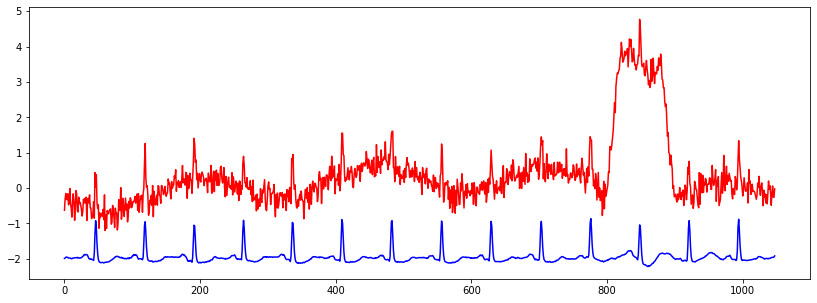

In [8]:
# load ECG data
ECG_data_clean = np.loadtxt('{}/example_data/original_ECG.txt'.format(download_directory))
ECG_data_noisy = np.loadtxt('{}/example_data/noisy_ECG.txt'.format(download_directory))

fig = plt.figure(figsize=(14, 5))
plt.plot(ECG_data_clean - 2 , color='b')
plt.plot(ECG_data_noisy, color='r')
plt.show()

***

## 2. Data Filtering
다양한 필터를 적용해보며 원하는 대역의 주파수만을 갖는 신호를 뽑아 봅시다.

### Bandpass filter 정의

본 강의에서는 다음과 같이 변수를 정의합니다. 
- `sampling_rate` : 데이터의 샘플랭 레이트, 본 실습에서는 100을 사용
- `lowcut` : 통과시킬 최소 주파수, 본 실습에서는 0.2 사용
- `highcut` : 통과시킬 최대 주파수, 본 실습에서는 30 사용

In [9]:
sampling_rate = 100
lowcut = 0.2
highcut = 30


# define butterworth filter
def butter_bandpass(data, lowcut, highcut, sampling_rate, order=4, plot_filter=False):
    nyq = 0.5 * sampling_rate # nyquist frequency
    wn_low = lowcut / nyq # Wn for highpass butterworth filter
    wn_high = highcut / nyq # Wn for lowpass butterworth filter
    # note that, Wn must be normalised to 0,1
    
    # calculate filter coefficients
    b, a = butter(order, [wn_low, wn_high], btype='band')
    
    # filter using linear filter function
    y = lfilter(b, a, data)
    
    if plot_filter:
        # plotting frequency response
        plt.figure()
        w, h = freqz(b, a, worN=2000)
        plt.plot((sampling_rate * 0.5 / np.pi) * w, abs(h), label='Butter order = %d' % order)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Gain')
        plt.grid(True)
        plt.legend(loc='best')
        
    return y

### Bandpass 필터를 활용한 ECG 데이터 처리
빨간색의 원본 신호가 파란색의 필터 신호와 같이 변화된 것을 확인할 수 있음

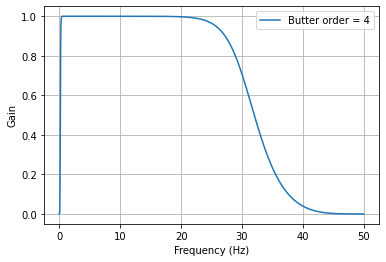

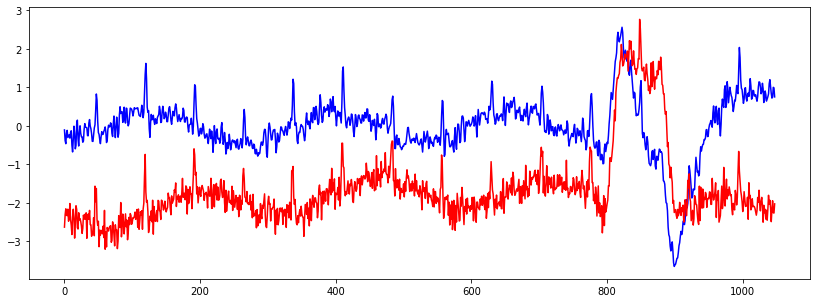

In [10]:
# filter the noisy ECG signal with butterworth filtering

filtered_ECG_butter = butter_bandpass(ECG_data_noisy, lowcut, highcut, sampling_rate, plot_filter=True)

fig = plt.figure(figsize=(14, 5))
plt.plot(filtered_ECG_butter, color='b')
plt.plot(ECG_data_noisy - 2 , color='r')

이를 원본 신호와 함께 비교해보면 다음과 같음

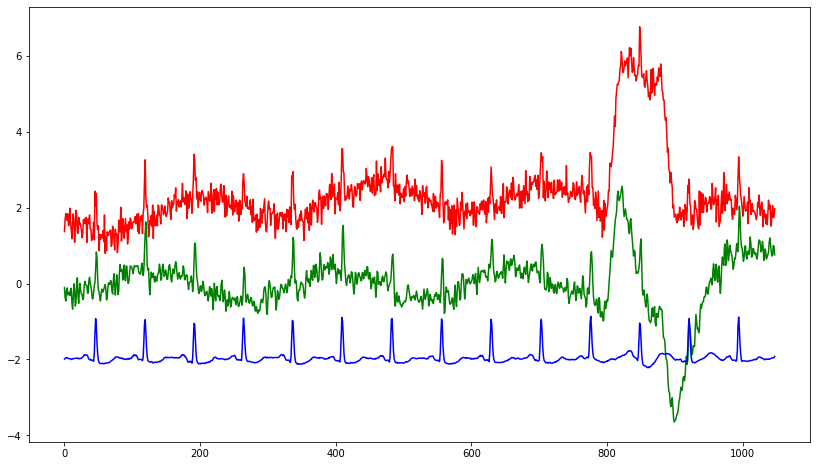

In [11]:
fig = plt.figure(figsize=(14, 8))
plt.plot(filtered_ECG_butter, color='g')
plt.plot(ECG_data_noisy + 2 , color='r')
plt.plot(ECG_data_clean - 2, color='b')

### Phase delay 를 고려한 Bandpass filter 정의
필터 설계시, `lfilter`(선형 필터)를 대신하여 `filtfilt`를 적용하여 phase delay를 해결할 수 있음 <br>
`filtfilt`는 선형 필터를 forward로 한번, backward로 한번으로 총 두번 적용하여 이를 merge 함 <br>
phase delay를 해결할 수 있다는 장점이 있으나, 처리된 신호의 앞부분과 뒷부분이 모두 다소 부정확해진다는 단점이 있음

In [12]:
# filter without pahse delay
def butter_bandpass_filtfilt(data, lowcut, highcut, sampling_rate, order=4, plot_filter=False):
    nyq = 0.5 * sampling_rate
    wn_low = lowcut / nyq
    wn_high = highcut / nyq
    
    # calculate filter coefficients
    b, a = butter(order, [wn_low, wn_high], btype='band')
    
    # filter using forward-backward linear filter
    # This function applies a linear digital filter twice, once forward and once backwards. The combined filter has zero phase and a filter order twice that of the original.
    y = filtfilt(b, a, data)
    return y

### Phase delay를 고려한 Bandpass 필터를 활용한 ECG 데이터 처리
`lfilter` (파란색 선) 적용 시 보다 `filtfilt` (초록색 선) 를 적용하였을 떄 baseline wandering 에 대한 대응이 약한것을 볼 수 있음

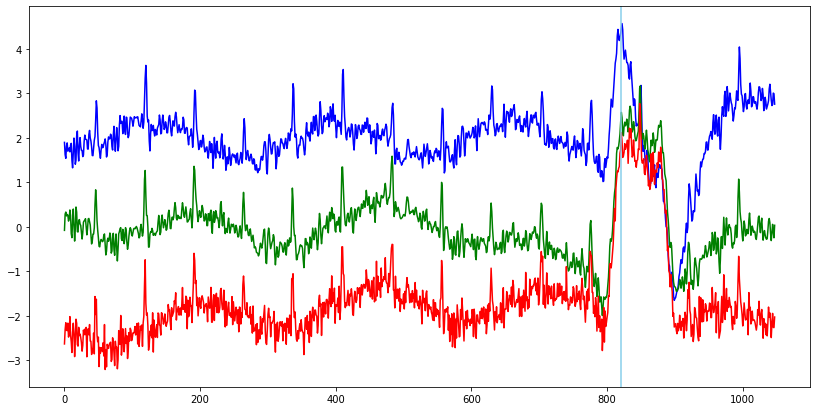

In [13]:
filtered_ECG_butter_filtfilt = butter_bandpass_filtfilt(ECG_data_noisy, lowcut, highcut, sampling_rate)
fig = plt.figure(figsize=(14,7))
plt.plot(filtered_ECG_butter+2, color='b')
plt.plot(filtered_ECG_butter_filtfilt, color='g')
plt.plot(ECG_data_noisy - 2 , color='r')
plt.axvline(x = 820, color = 'skyblue')

### 다양한 종류의 필터 적용 및 결과 비교

- `order=8`을 갖는 bandpass filter 적용 및 결과 비교

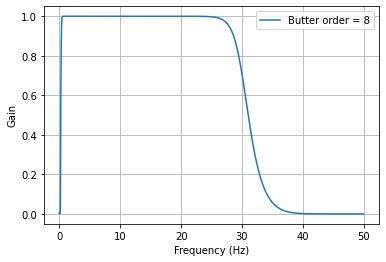

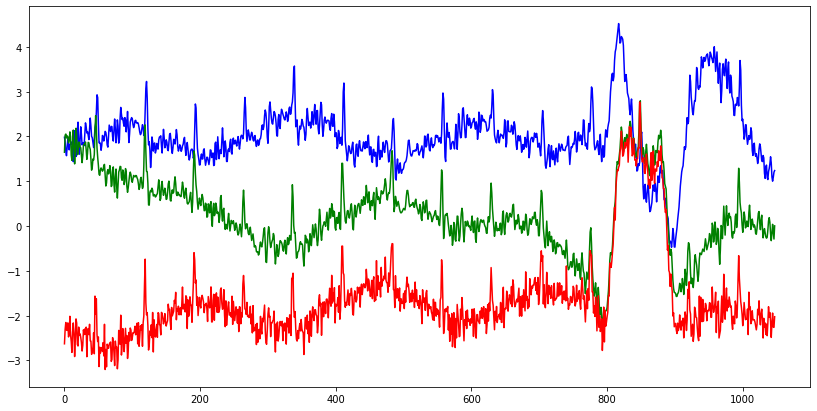

In [14]:
# filter with 8th order butterworth with and without phase shift
filtered_ECG_butter_8 = butter_bandpass(ECG_data_noisy, lowcut, highcut, sampling_rate, order=8, plot_filter=True)
filtered_ECG_butter_8_filtfilt = butter_bandpass_filtfilt(ECG_data_noisy, lowcut, highcut, sampling_rate, order=8)

fig = plt.figure(figsize=(14, 7))
plt.plot(filtered_ECG_butter_8 + 2, color='b')
plt.plot(filtered_ECG_butter_8_filtfilt, color='g')
plt.plot(ECG_data_noisy -2, color='r')

- chebychev filter 적용 및 결과 비교

In [15]:
# define chebychev filter

def cheby_bandpass(data, lowcut, highcut, sampling_rate, order=4, plot_filter=False):
    nyq = 0.5 * sampling_rate
    wn_low = lowcut / nyq
    wn_high = highcut / nyq
    
    # calculate filter coefficients
    b, a = cheby1(order, 0.5, [wn_low, wn_high], btype='band')
    
    # filter using linear filter
    y = lfilter(b, a, data)
    
    if plot_filter:
        plt.figure(1)
        plt.clf()
        w, h = freqz(b, a, worN=2000)
        plt.plot((sampling_rate * 0.5 / np.pi) * w, abs(h), label="cheby order %d" % order)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Gain')
        plt.grid(True)
        plt.legend(loc='best')
        
        
    return y

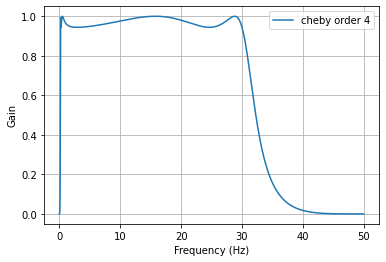

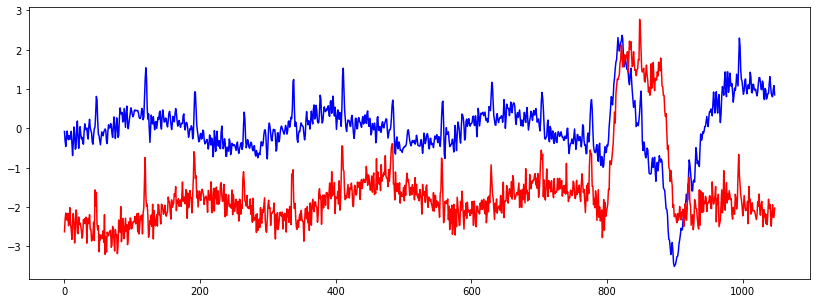

In [16]:
filtered_ECG_cheby = cheby_bandpass(ECG_data_noisy, lowcut, highcut, sampling_rate, plot_filter=True)
fig = plt.figure(figsize=(14, 5))
plt.plot(filtered_ECG_cheby, color='b')
plt.plot(ECG_data_noisy - 2, color='r')
plt.show()

***

## 3. Removal of Baseline wandering

### 선형 및 비선형 baseline 추정 알고리즘 정의

In [17]:
# define linear baseline removal function
def linear_baseline(data, window):
    y = data.copy()
    start_point = int(window/2)
    end_point = int(len(data) - window/2)
    for i in range(start_point, end_point):
        y[i] = np.mean(data[i - window//2: i + window//2])
    return y

In [18]:
# define non-linear baseline removal function
def nonlinear_baseline(data, window):
    y = data.copy()
    start_point = int(window/2)
    end_point = int(len(data) - window/2)
    for i in range(start_point, end_point):
        sorted_window = np.sort(data[i - window//2 : i + window//2]) # sort the values in window
        y[i] = np.mean(sorted_window[window//3:2*window//3]) # use only 33% to 66% of data to find mean
    return y

#### ECG 데이터 적용 및 plot

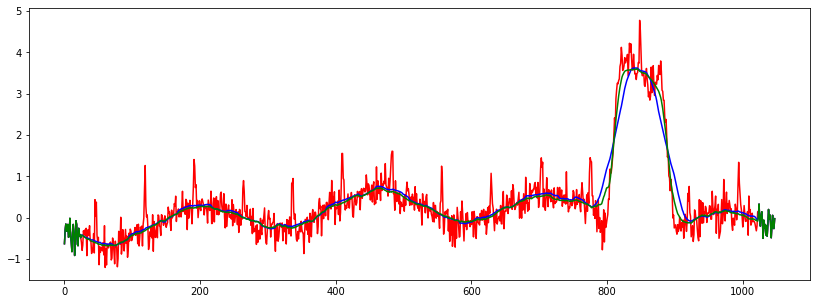

In [19]:
# plot baseline and the noisy ECG

baseline_lin = linear_baseline(ECG_data_noisy, 50)
baseline_nonlin = nonlinear_baseline(ECG_data_noisy, 50)

fig = plt.figure(figsize=(14, 5))
plt.plot(ECG_data_noisy, color='r')
plt.plot(baseline_lin, color='b')
plt.plot(baseline_nonlin, color='g')
plt.show()

### ECG Baseline removal
baseline removal 방법에 따라 서로 다른 결과를 가지는 것을 확인할 수 있음

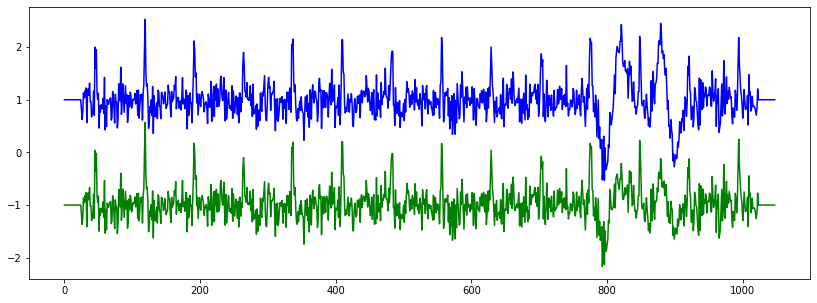

In [20]:
# plot ECG with baseline removed
bl_removed_ECG_lin = ECG_data_noisy - baseline_lin
bl_removed_ECG_nonlin = ECG_data_noisy - baseline_nonlin

fig = plt.figure(figsize=(14, 5))
plt.plot(bl_removed_ECG_lin + 1, color='b')
plt.plot(bl_removed_ECG_nonlin - 1, color='g')
plt.show()

***

## 4. Let's combine the two techniques!

### TODO: basline wandering이 제거된 신호에 `order=8`을 갖는 bandpass filter 적용하기

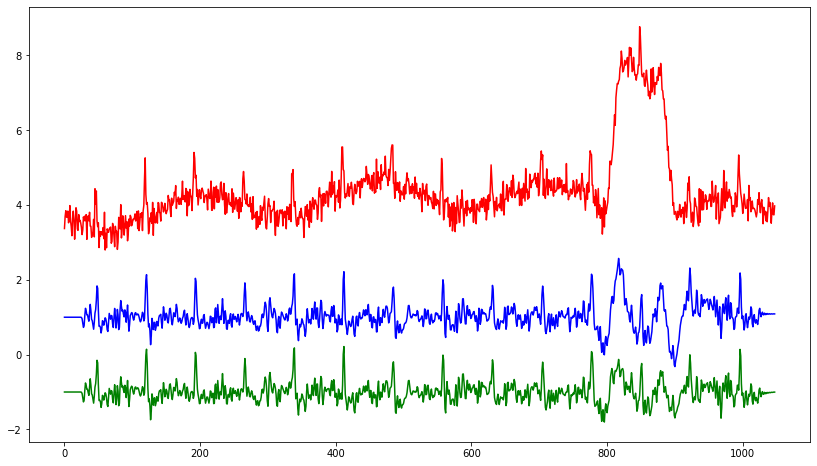

In [21]:
# bandpass filtering (order=8) with the noisy ECG after baseline removal

#=========== YOUR CODE HERE ========================

bl_remove_lin_filtered_ECG_butter = butter_bandpass(bl_removed_ECG_lin, lowcut, highcut, sampling_rate, order=8)
bl_remove_nonlin_filtered_ECG_butter = butter_bandpass(bl_removed_ECG_nonlin, lowcut, highcut, sampling_rate, order=8)

#===================================================

fig = plt.figure(figsize=(14, 8))
plt.plot(bl_remove_lin_filtered_ECG_butter + 1, color='b')
plt.plot(bl_remove_nonlin_filtered_ECG_butter - 1, color = 'g')
plt.plot(ECG_data_noisy + 4, color='r')

### 전처리된 신호로부터 R-peak detection

`neurokit2` 패키지의 `ecg_peak` 함수를 활용하여 R-peak detection 수행 <br>
- 1. linear baseline removal을 수행한 데이터에서 r-peak detection 및 plot

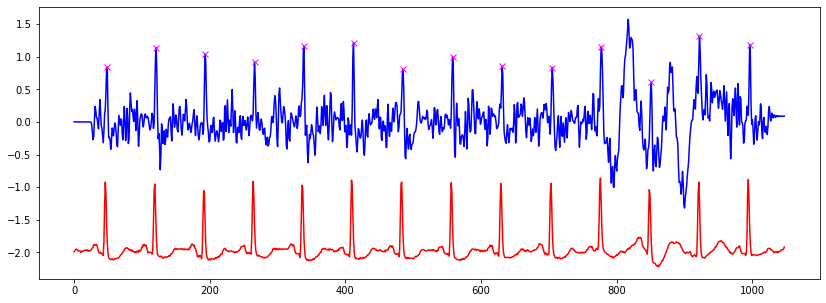

In [22]:
# detect r-peak from pre-processing signal using linear baseline removal and bandpass filtering
singal, info = nk.ecg_peaks(bl_remove_lin_filtered_ECG_butter, sampling_rate=sampling_rate)
r_peaks = info['ECG_R_Peaks']

plt.figure(figsize=(14, 5))
plt.plot(bl_remove_lin_filtered_ECG_butter, color='b')
plt.plot(ECG_data_clean - 2, 'r')
plt.plot(r_peaks, bl_remove_lin_filtered_ECG_butter[r_peaks], "x", color='magenta')

- 2. **TODO**: non-linear baseline removal을 수행한 데이터에서 r-peak detection 및 plot

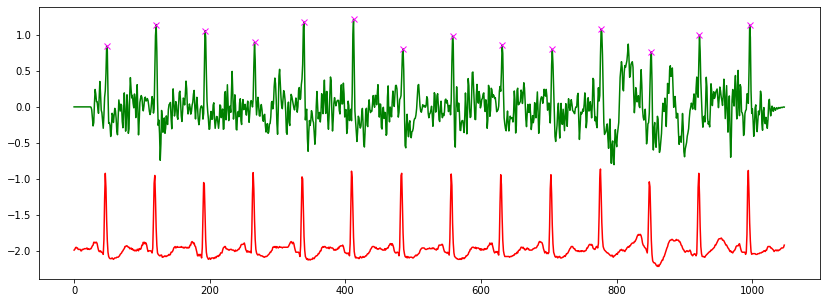

In [23]:
# detect r-peak from pre-processing signal using nonlinear baseline removal and bandpass filtering


#=========== YOUR CODE HERE ========================

singal, info = nk.ecg_peaks(bl_remove_nonlin_filtered_ECG_butter, sampling_rate=sampling_rate)
r_peaks = info['ECG_R_Peaks']


plt.figure(figsize=(14, 5))
plt.plot(bl_remove_nonlin_filtered_ECG_butter, color='g')
plt.plot(ECG_data_clean - 2, 'r')
plt.plot(r_peaks, bl_remove_nonlin_filtered_ECG_butter[r_peaks], "x", color='magenta')

#===================================================

### Same works for PPG signal
앞서 ECG 처리에서 사용된 동일한 프로세스를 적용하여 PPG 신호를 처리하고 plot 하여 결과를 확인해봅시다.

#### Data Loading

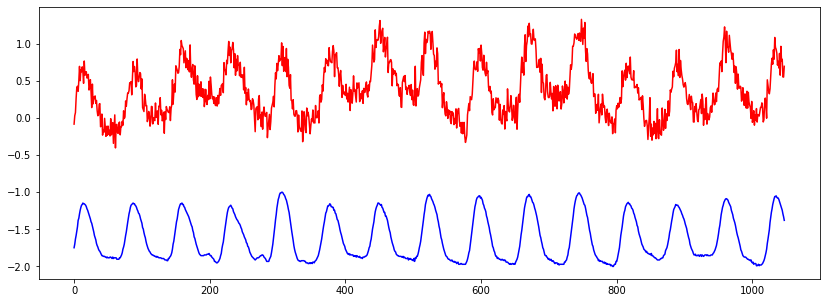

In [25]:
# Process PPG

# load PPG data
PPG_data_clean = np.loadtxt('{}/example_data/original_PPG.txt'.format(download_directory))
PPG_data_noisy = np.loadtxt('{}/example_data/noisy_PPG.txt'.format(download_directory))

# plot PPG signals
fig = plt.figure(figsize=(14, 5))
plt.plot(PPG_data_noisy, color='r')
plt.plot(PPG_data_clean-2, color='b')



#### **TODO**: noisy PPG 신호에 non-linear baseline removal 을 수행하고 `order=8`을 갖는 bandpass filter 를 적용하여 필터링

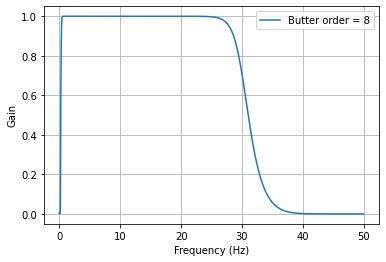

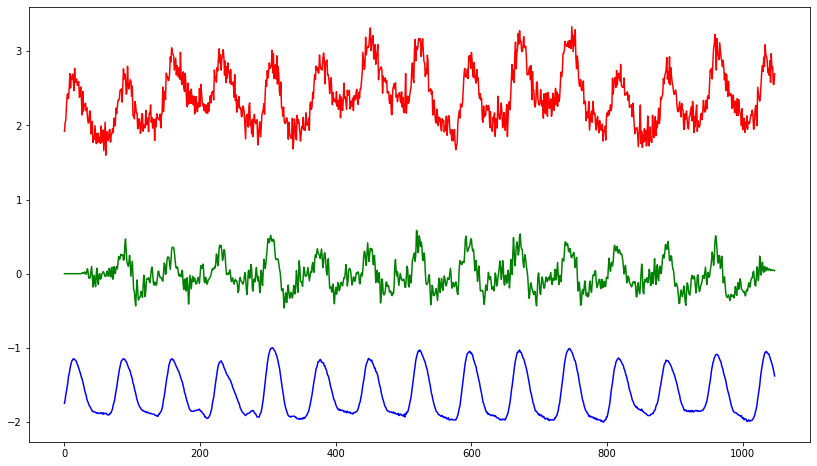

In [26]:
# pre-process noisy PPG signal using nonlinear baseline removal and butterworth bandpass fitlering (order=8)

#=========== YOUR CODE HERE ========================

baseline_ppg = nonlinear_baseline(PPG_data_noisy, 50)
bl_removed_PPG = PPG_data_noisy - baseline_ppg
bl_removed_filtered_PPG_butter = butter_bandpass(bl_removed_PPG, lowcut, highcut, sampling_rate, order=8, plot_filter=True)

#===================================================

fig = plt.figure(figsize=(14, 8))
plt.plot(PPG_data_noisy + 2, color='r')
plt.plot(bl_removed_filtered_PPG_butter, color='g')
plt.plot(PPG_data_clean - 2, color='b')

***

## 5. Real world dataset (VitalDB) and Packages

### Data Loading

In [27]:
sample_vital_file = vitaldb.VitalFile('{}/example_data/sample_vital_ecg.vital'.format(download_directory))
print(sample_vital_file.get_track_names())

['SNUADC/ART', 'SNUADC/ECG_II', 'SNUADC/PLETH', 'Solar8000/HR', 'Solar8000/ART_MBP', 'Solar8000/ART_SBP', 'Solar8000/ART_DBP', 'Solar8000/PLETH_SPO2', 'Solar8000/RR_CO2']


데이터의 샘플 구간 (10s) 추출 및 출력

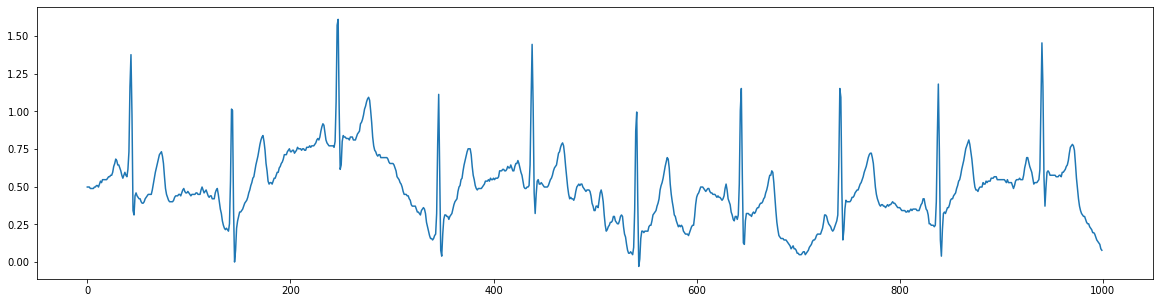

In [28]:
ecg_arr = sample_vital_file.to_numpy(track_names = ['SNUADC/ECG_II'], interval = 1/100) # 100hz sampling
ecg_arr = ecg_arr[~np.isnan(ecg_arr)]
ecg_samp = ecg_arr[500:1500] # 10s

fig = plt.figure(figsize=(20, 5))
plt.plot(ecg_samp)

### Baseline removal과 bandpass filtering 적용

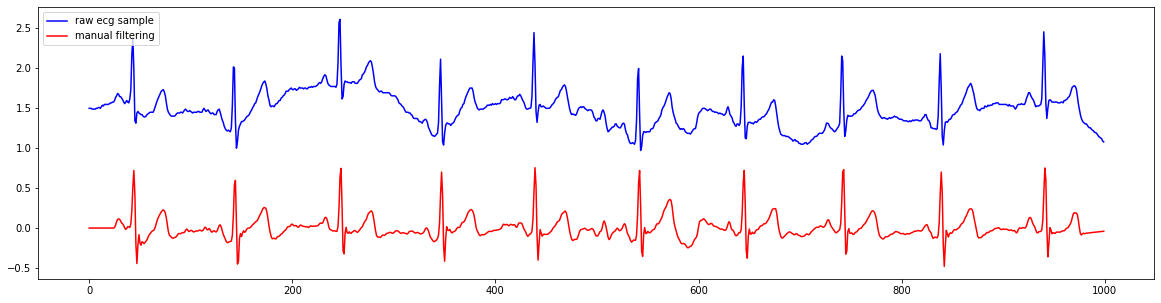

In [29]:
bl_ecg_samp = nonlinear_baseline(ecg_samp, 50)
remove_wandering_ecg_samp = ecg_samp - bl_ecg_samp
filtered_ecg_manual = butter_bandpass(remove_wandering_ecg_samp, lowcut, highcut, sampling_rate, order=4)

fig = plt.figure(figsize=(20, 5))
plt.plot(ecg_samp + 1, color='b', label = 'raw ecg sample')
plt.plot(filtered_ecg_manual, color='r', label = 'manual filtering')
plt.legend(loc='upper left')

### 다른 패키지를 활용한 전처리 결과 비교
생체신호 처리를 위한 다양한 패키지들이 이미 공개되어 있습니다. <br>
- `pyvital` : 서울대병원 VitalDB 팀에서 제공하는 생체신호 전처리 패키지
- `heartpy` : 심전도 처리에 특화된 전처리 패키지
- `neurokit2` : 각종 생체신호 처리 알고리즘을 지원하는 전처리 패키지
<br>

각 패키지마다 사용법이 조금씩 다르고, 구현의 기준이 된 알고리즘이 다르니 확인이 필요합니다. <br>
알고리즘마다 전처리의 결과가 다소 차이가 있을 수 있습니다.<br>

<br>


예를 들어, `heartpy`의 필터링 함수에서는 다음의 타입의 필터 함수를 지원합니다.<br>
> - lowpass : a lowpass butterworth filter 
> - highpass : a highpass butterworth filter 
> - bandpass : a bandpass butterworth filter 
> - notch : a notch filter around specified frequency range both the highpass and notch filter are useful for removing baseline wander. <br>
The notch filter is especially useful for removing baseling wander in ECG signals.

또한, `neurokit2`에서는 다음의 필터링 방법을 제공합니다.
> - 'neurokit' (default): 0.5 Hz high-pass butterworth filter (order = 5), followed by powerline filtering (see signal_filter()). By default, powerline = 50.
> - 'biosppy': Same as in the biosppy package. 
> - 'pantompkins1985': Method used in Pan & Tompkins (1985).
> - 'hamilton2002': Method used in Hamilton (2002). 
> - 'elgendi2010': Method used in Elgendi et al. (2010).
> - 'engzeemod2012': Method used in Engelse & Zeelenberg (1979). 

각 패키지별 필터링 및 r-peak detection 수행 결과는 다음과 같습니다.

In [31]:
# To be honest, there is easy way... all-in-one solutions


# with pyvital method - bandpass filter
filtered_ecg_pv = arr.band_pass(ecg_samp, sampling_rate, lowcut, highcut)


# heartpy - bandpass filter
filtered_ecg_hp_bp = hp.filter_signal(ecg_samp, cutoff=[lowcut, highcut], sample_rate=sampling_rate, filtertype='bandpass')
wd_bp, m_bp = hp.process(hp.scale_data(filtered_ecg_hp_bp), sampling_rate)


# heartpy - notch filter
filtered_ecg_hp_nc = hp.filter_signal(ecg_samp, cutoff=0.5, sample_rate=sampling_rate, filtertype = 'notch')
wd_nc, m_nc = hp.process(hp.scale_data(filtered_ecg_hp_nc), sampling_rate)


# neurokit - with pantompkins method
filtered_ecg_nk_pan, info_pan = nk.ecg_process(ecg_samp, sampling_rate=sampling_rate, method='pantompkins1985')


# neurokit - with 0.5Hz high-pass butterworth filter (order=5)
filtered_ecg_nk_nk, info_nk = nk.ecg_process(ecg_samp, sampling_rate=sampling_rate)

Text(0, -6.5, 'pyvital(bandpass)')

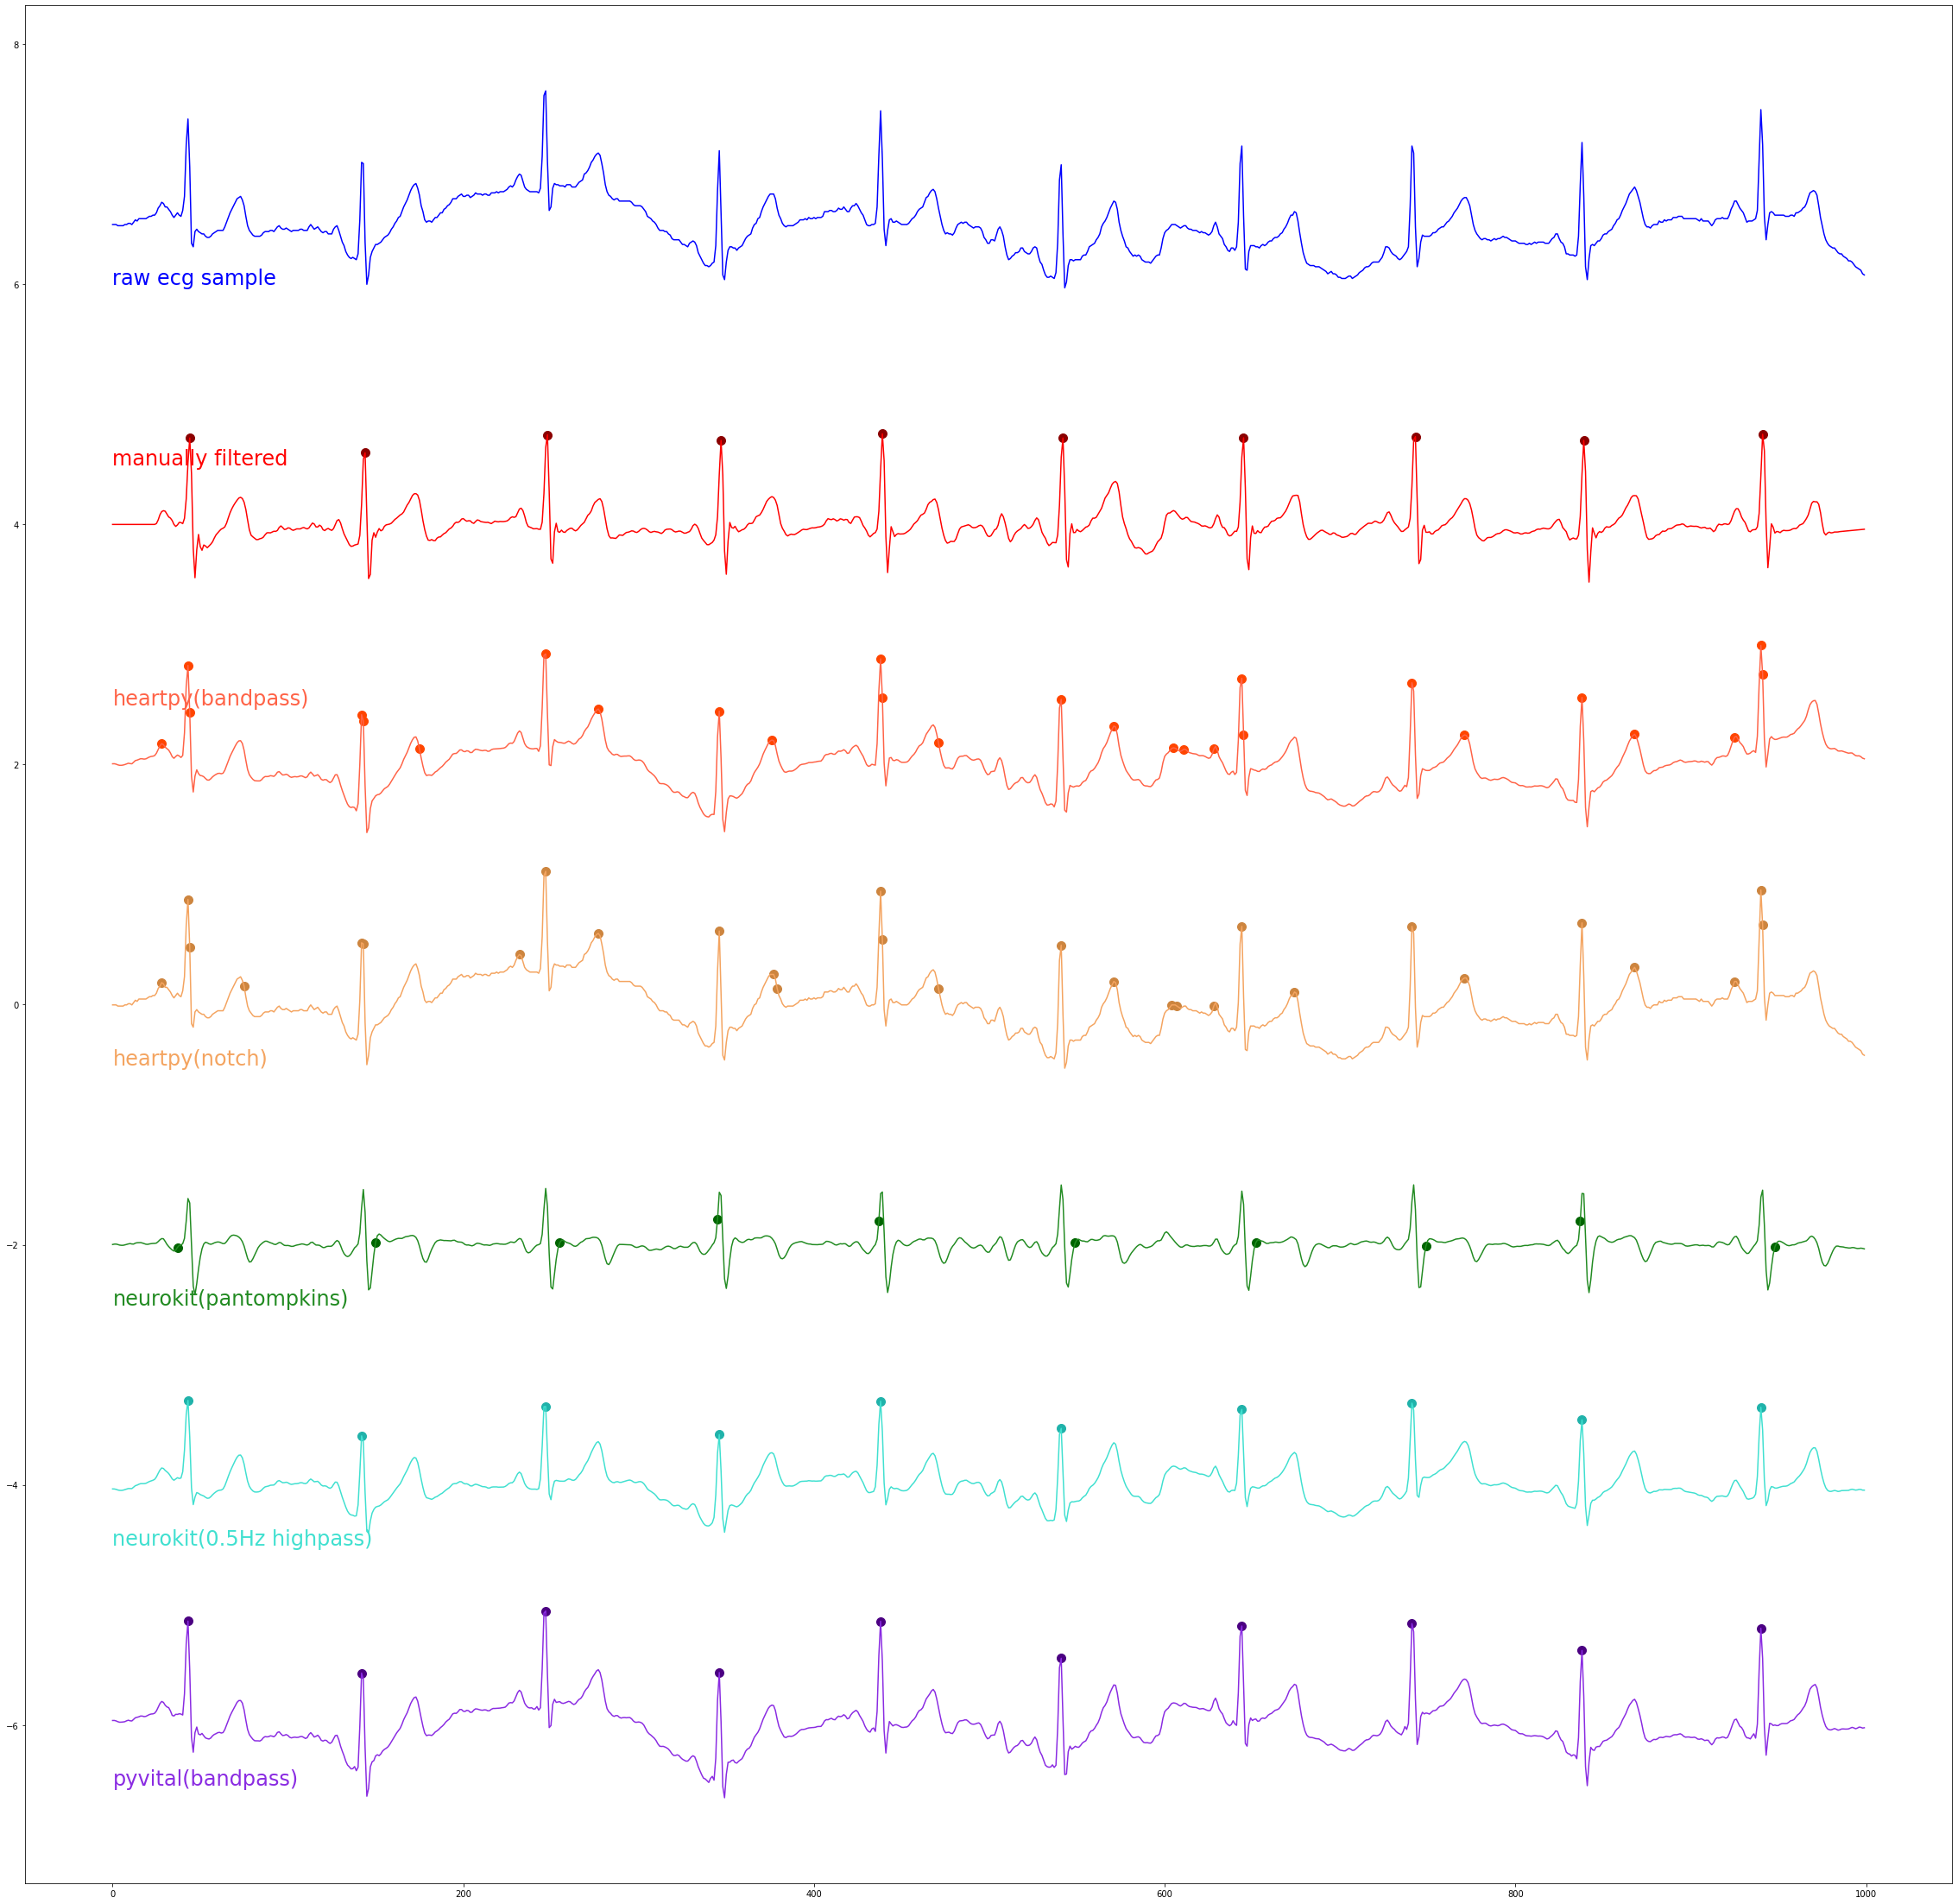

In [32]:
plt.figure(figsize = (40, 40))
plt.plot(ecg_samp + 6, color='blue', label='raw ecg sample')

plt.plot(filtered_ecg_manual+ 4, label='manually filtered', color='red')
r_peaks = arr.detect_qrs(filtered_ecg_manual, sampling_rate)
plt.scatter(y=filtered_ecg_manual[r_peaks] + 4, x=r_peaks, color='darkred', s=100)


plt.plot(filtered_ecg_hp_bp + 2, label='heartpy(bandpass)', color='tomato')
r_peaks = wd_bp['peaklist']
plt.scatter(y=filtered_ecg_hp_bp[r_peaks] + 2, x=r_peaks, color='orangered', s=100)


plt.plot(filtered_ecg_hp_nc - 0.5, label='heartpy(notch)', color='sandybrown')
r_peaks = wd_nc['peaklist']
plt.scatter(y=filtered_ecg_hp_nc[r_peaks] - 0.5, x=r_peaks, color='peru', s=100)


plt.plot(filtered_ecg_nk_pan['ECG_Clean'] -2, label='neurokit(pantompkins)', color='forestgreen')
r_peaks = list(info_pan['ECG_R_Peaks'])
plt.scatter(y=filtered_ecg_nk_pan['ECG_Clean'][r_peaks] -2, x=r_peaks, color='darkgreen', s=100)


plt.plot(filtered_ecg_nk_nk['ECG_Clean'] - 4, label='neurokit(0.5Hz highpass)', color='turquoise')
r_peaks = list(info_nk['ECG_R_Peaks'])
plt.scatter(y=filtered_ecg_nk_nk['ECG_Clean'][r_peaks] - 4, x=r_peaks, color='lightseagreen', s=100)


plt.plot(filtered_ecg_pv - 6, label='pyvital(bandpass)', color='blueviolet')
r_peaks = arr.detect_qrs(filtered_ecg_pv, sampling_rate)
plt.scatter(y=filtered_ecg_pv[r_peaks] - 6, x=r_peaks, color='indigo', s=100)


#plt.legend(loc='upper right', fontsize=24)
plt.text(0, 6, 'raw ecg sample', {'color':'blue', 'fontsize':24})
plt.text(0, 4.5, 'manually filtered', {'color':'red', 'fontsize':24})
plt.text(0, 2.5, 'heartpy(bandpass)', {'color':'tomato', 'fontsize':24})
plt.text(0, -0.5, 'heartpy(notch)', {'color':'sandybrown', 'fontsize':24})
plt.text(0, -2.5, 'neurokit(pantompkins)', {'color':'forestgreen', 'fontsize':24})
plt.text(0, -4.5, 'neurokit(0.5Hz highpass)', {'color':'turquoise', 'fontsize':24})
plt.text(0, -6.5, 'pyvital(bandpass)', {'color':'blueviolet', 'fontsize':24})